# Training a neural network with McSnow selfcollection output

This script applies a DNN to the regression problem compare with Seifert and Beheng (2001)

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


### Load Tensorflow and other useful modules

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


### Load data from netcdf

In [2]:
import numpy as np
import xarray as xr

In [3]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="big_n5"

fname1=mdir+edir+'autocon_train_'+data+'.nc'
fname2=mdir+edir+'autocon_test_'+data+'.nc'
fname3=mdir+edir+'autocon_val_big_n2.nc'

ds1 = xr.open_dataset(fname1)
ds2 = xr.open_dataset(fname2)
ds3 = xr.open_dataset(fname3)

print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:     (i: 6, ii: 6, j: 7, jj: 7, k: 5, kk: 5, n: 5, nn: 5, nt: 4000)
Coordinates:
  * n           (n) int32 0 1 2 3 4
  * i           (i) int32 200 400 600 800 1000 2000
  * j           (j) int32 9 10 11 12 13 14 15
  * k           (k) int32 0 1 2 3 4
Dimensions without coordinates: ii, jj, kk, nn, nt
Data variables:
    time        (n, i, j, k, nt) float32 ...
    tau         (n, i, j, k, nt) float32 ...
    Lc          (n, i, j, k, nt) float32 ...
    Nc          (n, i, j, k, nt) float32 ...
    Zc          (n, i, j, k, nt) float32 ...
    Lr          (n, i, j, k, nt) float32 ...
    Nr          (n, i, j, k, nt) float32 ...
    Zr          (n, i, j, k, nt) float32 ...
    nu          (n, i, j, k, nt) float32 ...
    mue         (n, i, j, k, nt) float64 ...
    nue         (n, i, j, k, nt) float64 ...
    auto_num    (n, i, j, k, nt) float32 ...
    auto_mass   (n, i, j, k, nt) float32 ...
    accr_num    (n, i, j, k, nt) float32 ...
    accr_mass   (n

# Prepare data for training

In [4]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    self = xr.open_dataset(fname).self_cloud.values
    Lc   = xr.open_dataset(fname).Lc.values
    Nc   = xr.open_dataset(fname).Nc.values
    nu   = xr.open_dataset(fname).nu.values  # this is nu0, nue is the time-dependent shape
    tau  = xr.open_dataset(fname).tau.values
    # transform everything except nu in log space
    L_min = 1e-15
    N_min = 1e-15
    tau_min  = 1e-15
    self_min = 1e-15
    Xc = np.log(Lc/Nc, where=Nc>N_min)
    Nc = np.log(Nc, where=Nc>N_min)
    Lc = np.log(Lc, where=Lc>L_min)
    tau = np.log(tau, where=tau>tau_min, out=np.nan*tau)    
    self = np.log(self, where=self>self_min, out=np.nan*self)
    # put everything in a pandas dataframe    
    dataset = pd.DataFrame(np.array( [ self.ravel(), Lc.ravel(), Nc.ravel(), Xc.ravel(), nu.ravel(), tau.ravel() ]))
    dataset = dataset.T
    dataset.columns = [ 'self','Lc','Nc','Xc','nu','tau' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [5]:
dataset_train = read_and_prepare_data(fname1)
dataset_test  = read_and_prepare_data(fname2)
dataset_val   = read_and_prepare_data(fname3)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


### Inspect the data

In [6]:
dataset_train.describe()

self             Lc             Nc             Xc  \
count  365705.000000  365705.000000  365705.000000  365705.000000   
mean        4.318351      -9.091941      16.847563     -25.938072   
std         4.406728       1.900657       1.763940       0.609480   
min       -17.727533     -15.428405      10.203978     -28.906904   
25%         2.342306     -10.177835      15.766764     -26.403944   
50%         5.674793      -8.520574      17.298132     -25.905914   
75%         7.480394      -7.825369      18.052843     -25.466192   
max        11.287971      -6.215683      20.282543     -24.881920   

                  nu            tau  
count  365705.000000  365705.000000  
mean        2.102441      -5.309586  
std         1.390323       6.839194  
min         0.000000     -30.585890  
25%         1.000000      -8.140707  
50%         2.000000      -2.339488  
75%         3.000000      -0.100994  
max         4.000000      -0.001000

In [7]:
dataset_test.describe()

self             Lc             Nc             Xc  \
count  220119.000000  220119.000000  220119.000000  220119.000000   
mean        4.663981      -8.951715      16.960733     -25.918514   
std         4.536104       1.964395       1.859921       0.564976   
min       -17.727533     -15.020370      10.667000     -28.124483   
25%         2.494155     -10.203300      15.732335     -26.398561   
50%         6.462418      -8.115395      17.524529     -25.896553   
75%         7.825904      -7.602365      18.329402     -25.450516   
max        10.677000      -6.503471      19.994093     -24.882586   

                  nu            tau  
count  220119.000000  220119.000000  
mean        2.053578      -5.233242  
std         1.108732       6.820485  
min         0.500000     -30.294912  
25%         1.500000      -8.069777  
50%         2.500000      -2.174195  
75%         3.500000      -0.074978  
max         3.500000      -0.001001

In [8]:
dataset_val.describe()

self             Lc             Nc             Xc  \
count  145639.000000  145639.000000  145639.000000  145639.000000   
mean        4.345058      -9.080858      16.852318     -25.938025   
std         4.372805       1.891776       1.758360       0.606335   
min       -17.727533     -15.421450      10.149014     -28.913774   
25%         2.413308     -10.151951      15.781311     -26.402710   
50%         5.678273      -8.520212      17.301907     -25.899712   
75%         7.468668      -7.825404      18.048810     -25.459644   
max        11.272990      -6.215693      20.282999     -24.883766   

                  nu            tau  
count  145639.000000  145639.000000  
mean        2.108323      -5.317068  
std         1.393531       6.802872  
min         0.000000     -30.570148  
25%         1.000000      -8.192728  
50%         2.000000      -2.376833  
75%         3.000000      -0.103103  
max         4.000000      -0.001000

### Reduce the data

In [9]:
def reduce_data(dataset):
    idx = dataset[ dataset['Lc'] < np.log(1e-7) ].index
    dataset.drop(idx,inplace=True)
#    idx = dataset[ dataset['tau'] > np.log(0.95) ].index
#    dataset.drop(idx,inplace=True)
    return dataset

In [10]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

In [11]:
dataset_train.describe()

self             Lc             Nc             Xc  \
count  365705.000000  365705.000000  365705.000000  365705.000000   
mean        4.318351      -9.091941      16.847563     -25.938072   
std         4.406728       1.900657       1.763940       0.609480   
min       -17.727533     -15.428405      10.203978     -28.906904   
25%         2.342306     -10.177835      15.766764     -26.403944   
50%         5.674793      -8.520574      17.298132     -25.905914   
75%         7.480394      -7.825369      18.052843     -25.466192   
max        11.287971      -6.215683      20.282543     -24.881920   

                  nu            tau  
count  365705.000000  365705.000000  
mean        2.102441      -5.309586  
std         1.390323       6.839194  
min         0.000000     -30.585890  
25%         1.000000      -8.140707  
50%         2.000000      -2.339488  
75%         3.000000      -0.100994  
max         4.000000      -0.001000

In [12]:
dataset_test.describe()

self             Lc             Nc             Xc  \
count  220119.000000  220119.000000  220119.000000  220119.000000   
mean        4.663981      -8.951715      16.960733     -25.918514   
std         4.536104       1.964395       1.859921       0.564976   
min       -17.727533     -15.020370      10.667000     -28.124483   
25%         2.494155     -10.203300      15.732335     -26.398561   
50%         6.462418      -8.115395      17.524529     -25.896553   
75%         7.825904      -7.602365      18.329402     -25.450516   
max        10.677000      -6.503471      19.994093     -24.882586   

                  nu            tau  
count  220119.000000  220119.000000  
mean        2.053578      -5.233242  
std         1.108732       6.820485  
min         0.500000     -30.294912  
25%         1.500000      -8.069777  
50%         2.500000      -2.174195  
75%         3.500000      -0.074978  
max         3.500000      -0.001001

In [13]:
dataset_val.describe()

self             Lc             Nc             Xc  \
count  145639.000000  145639.000000  145639.000000  145639.000000   
mean        4.345058      -9.080858      16.852318     -25.938025   
std         4.372805       1.891776       1.758360       0.606335   
min       -17.727533     -15.421450      10.149014     -28.913774   
25%         2.413308     -10.151951      15.781311     -26.402710   
50%         5.678273      -8.520212      17.301907     -25.899712   
75%         7.468668      -7.825404      18.048810     -25.459644   
max        11.272990      -6.215693      20.282999     -24.883766   

                  nu            tau  
count  145639.000000  145639.000000  
mean        2.108323      -5.317068  
std         1.393531       6.802872  
min         0.000000     -30.570148  
25%         1.000000      -8.192728  
50%         2.000000      -2.376833  
75%         3.000000      -0.103103  
max         4.000000      -0.001000

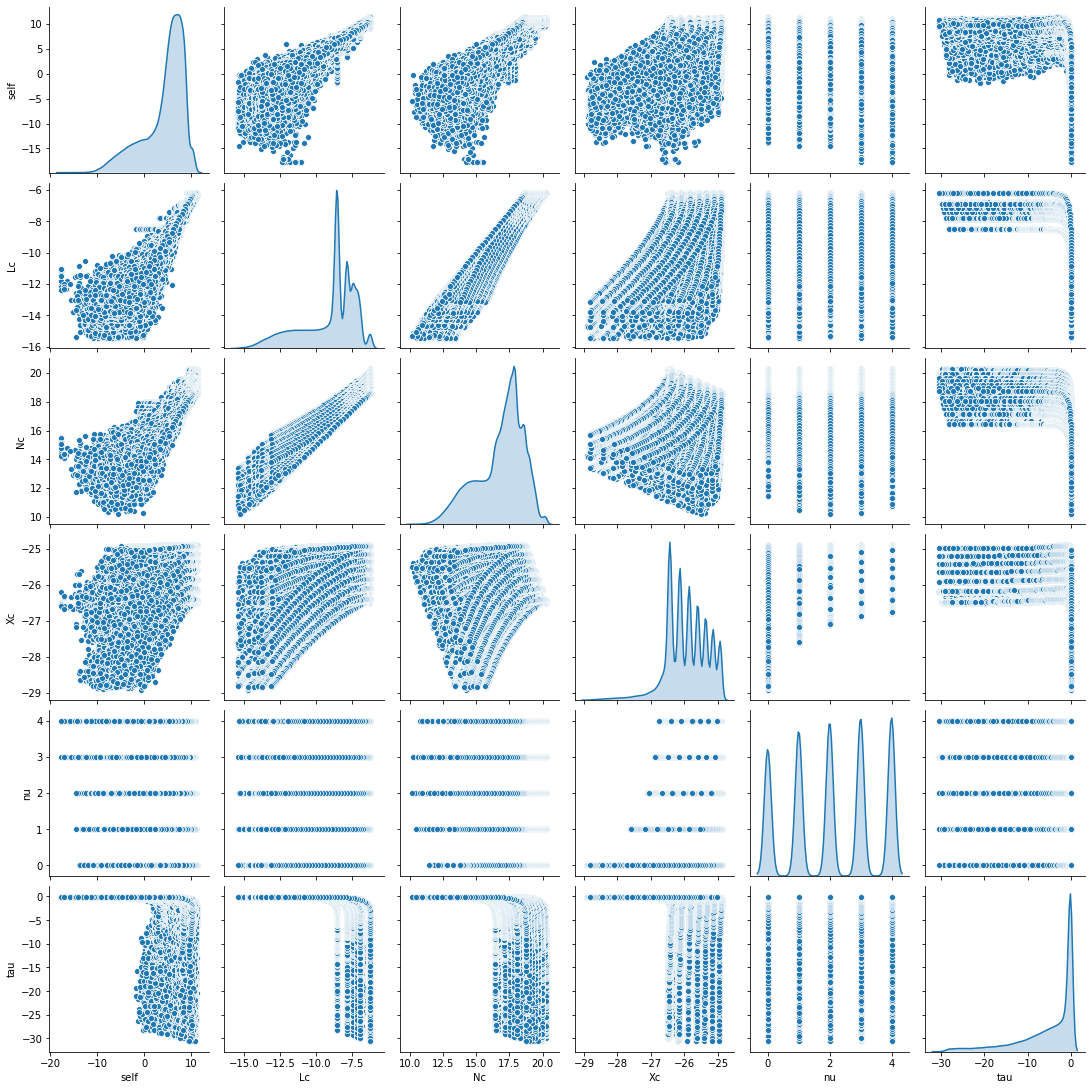

In [14]:
sns.pairplot(dataset_train[['self','Lc','Nc','Xc','nu','tau']], diag_kind="kde")

## Separate in different dataset with selected sets of predictors

In [15]:
train_dataset0 = dataset_train.copy()
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()

test_dataset0 = dataset_test.copy()
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()

val_dataset0 = dataset_val.copy()
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()
val_dataset4 = dataset_val.copy()

In [16]:
train_dataset0 = train_dataset0.drop(['Xc','nu','tau'], axis=1)
train_dataset1 = train_dataset1.drop(['Nc','nu','tau'], axis=1)
train_dataset2 = train_dataset2.drop(['Xc','tau'], axis=1)
train_dataset3 = train_dataset3.drop(['Nc','tau'], axis=1)
train_dataset4 = train_dataset4.drop(['Nc'], axis=1)

In [17]:
test_dataset0 = test_dataset0.drop(['Xc','nu','tau'], axis=1)
test_dataset1 = test_dataset1.drop(['Nc','nu','tau'], axis=1)
test_dataset2 = test_dataset2.drop(['Xc','tau'], axis=1)
test_dataset3 = test_dataset3.drop(['Nc','tau'], axis=1)
test_dataset4 = test_dataset4.drop(['Nc'], axis=1)

In [18]:
val_dataset0 = val_dataset0.drop(['Xc','nu','tau'], axis=1)
val_dataset1 = val_dataset1.drop(['Nc','nu','tau'], axis=1)
val_dataset2 = val_dataset2.drop(['Xc','tau'], axis=1)
val_dataset3 = val_dataset3.drop(['Nc','tau'], axis=1)
val_dataset4 = val_dataset4.drop(['Nc'], axis=1)

In [19]:
train_stats0 = train_dataset0.describe()
train_stats0.pop("self")
train_stats0 = train_stats0.transpose()
train_stats0

count       mean       std        min        25%        50%        75%  \
Lc  365705.0  -9.091941  1.900657 -15.428405 -10.177835  -8.520574  -7.825369   
Nc  365705.0  16.847563  1.763940  10.203978  15.766764  17.298132  18.052843   

          max  
Lc  -6.215683  
Nc  20.282543

In [20]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("self")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%        75%  \
Lc  365705.0  -9.091941  1.900657 -15.428405 -10.177835  -8.520574  -7.825369   
Xc  365705.0 -25.938072  0.609480 -28.906904 -26.403944 -25.905914 -25.466192   

          max  
Lc  -6.215683  
Xc -24.881920

In [21]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("self")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%        75%  \
Lc  365705.0  -9.091941  1.900657 -15.428405 -10.177835  -8.520574  -7.825369   
Nc  365705.0  16.847563  1.763940  10.203978  15.766764  17.298132  18.052843   
nu  365705.0   2.102441  1.390323   0.000000   1.000000   2.000000   3.000000   

          max  
Lc  -6.215683  
Nc  20.282543  
nu   4.000000

In [22]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("self")
train_stats3 = train_stats3.transpose()
train_stats3

count       mean       std        min        25%        50%        75%  \
Lc  365705.0  -9.091941  1.900657 -15.428405 -10.177835  -8.520574  -7.825369   
Xc  365705.0 -25.938072  0.609480 -28.906904 -26.403944 -25.905914 -25.466192   
nu  365705.0   2.102441  1.390323   0.000000   1.000000   2.000000   3.000000   

          max  
Lc  -6.215683  
Xc -24.881920  
nu   4.000000

In [23]:
train_stats4 = train_dataset4.describe()
train_stats4.pop("self")
train_stats4 = train_stats4.transpose()
train_stats4

count       mean       std        min        25%        50%  \
Lc   365705.0  -9.091941  1.900657 -15.428405 -10.177835  -8.520574   
Xc   365705.0 -25.938072  0.609480 -28.906904 -26.403944 -25.905914   
nu   365705.0   2.102441  1.390323   0.000000   1.000000   2.000000   
tau  365705.0  -5.309586  6.839194 -30.585890  -8.140707  -2.339488   

           75%        max  
Lc   -7.825369  -6.215683  
Xc  -25.466192 -24.881920  
nu    3.000000   4.000000  
tau  -0.100994  -0.001000

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [24]:
train_labels0 = train_dataset0.pop('self')
train_labels1 = train_dataset1.pop('self')
train_labels2 = train_dataset2.pop('self')
train_labels3 = train_dataset3.pop('self')
train_labels4 = train_dataset4.pop('self')

test_labels0  = test_dataset0.pop('self')
test_labels1  = test_dataset1.pop('self')
test_labels2  = test_dataset2.pop('self')
test_labels3  = test_dataset3.pop('self')
test_labels4  = test_dataset4.pop('self')

In [25]:
val_labels0  = val_dataset0.pop('self')
val_labels1  = val_dataset1.pop('self')
val_labels2  = val_dataset2.pop('self')
val_labels3  = val_dataset3.pop('self')
val_labels4  = val_dataset4.pop('self')

### Normalize the data

In [26]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data0 = norm(train_dataset0,train_stats0)
normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)
normed_train_data4 = norm(train_dataset4,train_stats4)

normed_test_data0 = norm(test_dataset0,train_stats0)
normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)
normed_test_data4 = norm(test_dataset4,train_stats4)

normed_val_data0 = norm(val_dataset0,train_stats0)
normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)
normed_val_data4 = norm(val_dataset4,train_stats4)

In [27]:
normed_train_stats0 = normed_train_data0.describe()
normed_train_stats0 = normed_train_stats0.transpose()
normed_train_stats0

count      mean       std       min       25%       50%       75%  \
Lc  365705.0 -0.000773  0.999908 -3.333829 -0.571326  0.300616  0.666386   
Nc  365705.0  0.000145  1.000031 -3.766333 -0.612719  0.255433  0.683289   

         max  
Lc  1.513297  
Nc  1.947334

In [28]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count      mean       std       min       25%       50%       75%  \
Lc  365705.0 -0.000773  0.999908 -3.333829 -0.571326  0.300616  0.666386   
Xc  365705.0 -0.005179  1.000018 -4.871091 -0.764376  0.052763  0.774234   

         max  
Lc  1.513297  
Xc  1.732875

In [29]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean       std       min       25%       50%       75%  \
Lc  365705.0 -7.728494e-04  0.999908 -3.333829 -0.571326  0.300616  0.666386   
Nc  365705.0  1.453037e-04  1.000031 -3.766333 -0.612719  0.255433  0.683289   
nu  365705.0 -7.478384e-08  1.000137 -1.512195 -0.792938 -0.073681  0.645576   

         max  
Lc  1.513297  
Nc  1.947334  
nu  1.364833

In [30]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean       std       min       25%       50%       75%  \
Lc  365705.0 -7.728494e-04  0.999908 -3.333829 -0.571326  0.300616  0.666386   
Xc  365705.0 -5.179326e-03  1.000018 -4.871091 -0.764376  0.052763  0.774234   
nu  365705.0 -7.478384e-08  1.000137 -1.512195 -0.792938 -0.073681  0.645576   

         max  
Lc  1.513297  
Xc  1.732875  
nu  1.364833

In [31]:
normed_train_stats4 = normed_train_data4.describe()
normed_train_stats4 = normed_train_stats4.transpose()
normed_train_stats4

count          mean       std       min       25%       50%       75%  \
Lc   365705.0 -7.728494e-04  0.999908 -3.333829 -0.571326  0.300616  0.666386   
Xc   365705.0 -5.179326e-03  1.000018 -4.871091 -0.764376  0.052763  0.774234   
nu   365705.0 -7.478384e-08  1.000137 -1.512195 -0.792938 -0.073681  0.645576   
tau  365705.0 -2.455458e-04  1.000093 -3.695801 -0.413955  0.434276  0.761580   

          max  
Lc   1.513297  
Xc   1.732875  
nu   1.364833  
tau  0.776200

# The model

## Build the model

In [32]:
def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [33]:

#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
activ = "ReLU"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"

model = build_model(2,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [35]:
example_batch  = normed_train_data0[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.09353095],
       [-0.09352081],
       [-0.09351849],
       [-0.09350786],
       [-0.09350313],
       [-0.09349822],
       [-0.09348819],
       [-0.09348406],
       [-0.0934644 ],
       [-0.0934498 ]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [36]:
# maximum number, but we use early stopping
EPOCHS = 1000

# learning rate
learn = 1e-3        # original value was 1e-3

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# for collecting the histories
histories = {}

In [37]:
model0 = build_model(len(normed_train_data0.keys()),activ,learn)

early_history0 = model0.fit(normed_train_data0, train_labels0, 
                    epochs=EPOCHS, validation_data=[normed_val_data0,val_labels0], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:1.9446,  mae:0.9369,  mse:1.9446,  val_loss:1.6158,  val_mae:0.8763,  val_mse:1.6158,  
.............................................

Text(0, 0.5, 'MAE')

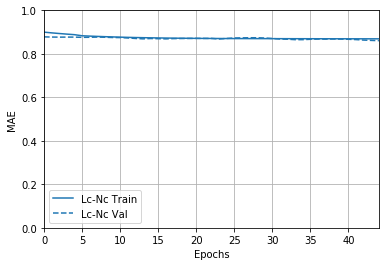

In [38]:
histories['Lc-Nc'] = early_history0

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [39]:
model1 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history1 = model1.fit(normed_train_data1, train_labels1, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,val_labels1], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:1.8820,  mae:0.9286,  mse:1.8820,  val_loss:1.6188,  val_mae:0.8873,  val_mse:1.6188,  
..........................................

Text(0, 0.5, 'MAE')

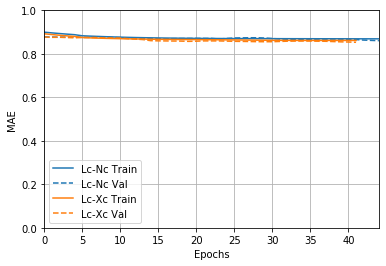

In [40]:
histories['Lc-Xc'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [41]:
model2 = build_model(len(normed_train_data2.keys()),activ,learn)

early_history2 = model2.fit(normed_train_data2, train_labels2, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,val_labels2], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:1.7672,  mae:0.8564,  mse:1.7672,  val_loss:1.3902,  val_mae:0.7952,  val_mse:1.3902,  
........................

Text(0, 0.5, 'MAE')

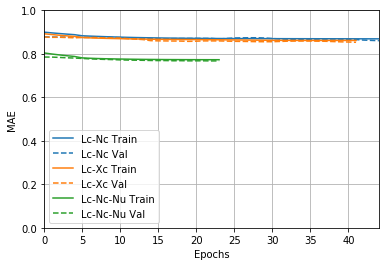

In [42]:
histories['Lc-Nc-nu'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [43]:
model3 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history3 = model3.fit(normed_train_data3, train_labels3, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,val_labels3], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:1.7619,  mae:0.8527,  mse:1.7619,  val_loss:1.3766,  val_mae:0.7862,  val_mse:1.3766,  
........................

Text(0, 0.5, 'MAE')

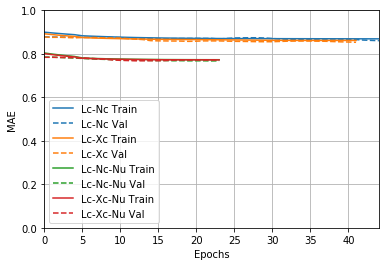

In [44]:
histories['Lc-Xc-nu'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [45]:
model4 = build_model(len(normed_train_data4.keys()),activ,learn)

early_history4 = model4.fit(normed_train_data4, train_labels4, 
                    epochs=EPOCHS, validation_data=[normed_val_data4,val_labels4], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:1.5800,  mae:0.8065,  mse:1.5800,  val_loss:1.2899,  val_mae:0.7510,  val_mse:1.2899,  
....................................

Text(0, 0.5, 'MAE')

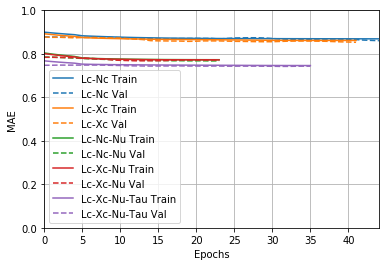

In [46]:
histories['Lc-Xc-nu-tau'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

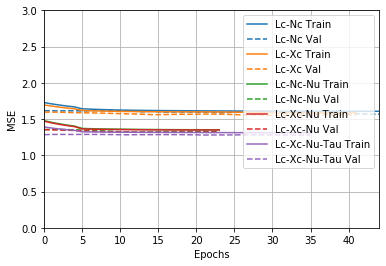

In [47]:
plotter.plot(histories, metric = "mse")
plt.ylim([0, 3])
plt.ylabel('MSE')

In [48]:
loss0, mae0, mse0 = model0.evaluate(normed_test_data0, test_labels0, verbose=2)

print("Testing set for model 0, Mean Abs Error: {:10.5f}".format(mae0))

220119/220119 - 5s - loss: 1.3383 - mae: 0.7722 - mse: 1.3383
Testing set for model 0, Mean Abs Error:    0.77217


In [49]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, test_labels1, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

220119/220119 - 5s - loss: 1.3763 - mae: 0.7802 - mse: 1.3763
Testing set for model 1, Mean Abs Error:    0.78017


In [50]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, test_labels2, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:10.5f}".format(mae2))

220119/220119 - 5s - loss: 1.1549 - mae: 0.6941 - mse: 1.1549
Testing set for model 2, Mean Abs Error:    0.69414


In [51]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, test_labels3, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:10.5f}".format(mae3))

220119/220119 - 5s - loss: 1.1596 - mae: 0.6974 - mse: 1.1596
Testing set for model 3, Mean Abs Error:    0.69736


In [52]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data4, test_labels4, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:10.5f}".format(mae4))

220119/220119 - 5s - loss: 1.0917 - mae: 0.6600 - mse: 1.0917
Testing set for model 4, Mean Abs Error:    0.65996


# Make predictions

Finally, predict the fall velocity values using data in the testing set:

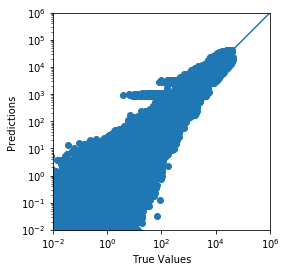

In [53]:
test_self0 = np.exp(test_labels0)
test_self1 = np.exp(test_labels1)
test_self2 = np.exp(test_labels2)
test_self3 = np.exp(test_labels3)
test_self4 = np.exp(test_labels4)

test_predict0 = np.exp(model0.predict(normed_test_data0).flatten())
test_predict1 = np.exp(model1.predict(normed_test_data1).flatten())
test_predict2 = np.exp(model2.predict(normed_test_data2).flatten())

amin, amax = 1e-2, 1e6

a = plt.axes(aspect='equal')
plt.scatter(test_self0, test_predict0)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

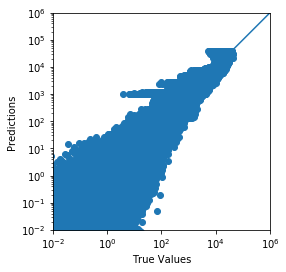

In [54]:
a = plt.axes(aspect='equal')
plt.scatter(test_self1, test_predict1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

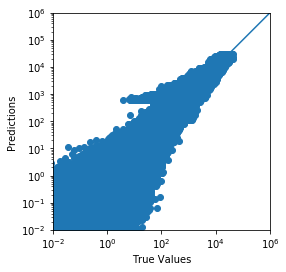

In [55]:
a = plt.axes(aspect='equal')
plt.scatter(test_self2, test_predict2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

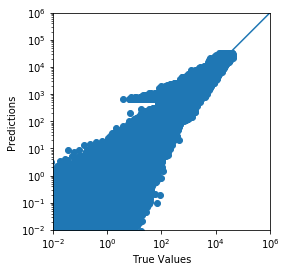

In [56]:
test_predict3 = np.exp(model3.predict(normed_test_data3).flatten())

a = plt.axes(aspect='equal')
plt.scatter(test_self3, test_predict3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

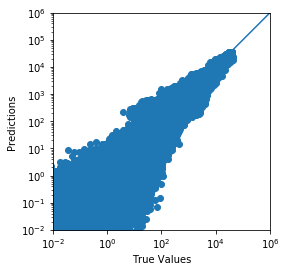

In [57]:
test_predict4 = np.exp(model4.predict(normed_test_data4).flatten())

a = plt.axes(aspect='equal')
plt.scatter(test_self4, test_predict4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Compare with SB2001 and KK2000

In [58]:
test_dataset2.describe()

Lc             Nc             nu
count  220119.000000  220119.000000  220119.000000
mean       -8.951715      16.960733       2.053578
std         1.964395       1.859921       1.108732
min       -15.020370      10.667000       0.500000
25%       -10.203300      15.732335       1.500000
50%        -8.115395      17.524529       2.500000
75%        -7.602365      18.329402       3.500000
max        -6.503471      19.994093       3.500000

## SB2001 autoconversion rate, original and re-trained on current data

In [59]:
kcr = 5.78       # Long kernel in m3 kg-1 s-1 
kcc = 9.44e9      # Long kernel in m3 kg-2 s-1 

qc  = np.exp(np.array(test_dataset2.Lc))
nc  = np.exp(np.array(test_dataset2.Nc))
nue = np.array(test_dataset2.nu)

selfSB = kcc * (nue+2)/(nue+1) * qc*qc

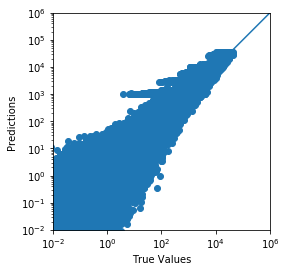

In [60]:
test_predict_sb = selfSB

a = plt.axes(aspect='equal')
plt.scatter(test_self4, test_predict_sb)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Final statistics 

In [61]:
self0 = test_predict0
self1 = test_predict1
self2 = test_predict2
self3 = test_predict3
self4 = test_predict4

selfTruth = test_self4

In [62]:
np.max(selfTruth)

43347.31640625

In [63]:
def mean_abs_error(var, varTrue):  
    return np.mean(np.abs(var - varTrue))

def mean_sqr_error(var, varTrue):    
    return np.sqrt(np.mean((var - varTrue)**2))                   

In [64]:
mae0 = mean_abs_error(self0,test_self0)
mae1 = mean_abs_error(self1,test_self1)
mae2 = mean_abs_error(self2,test_self2)
mae3 = mean_abs_error(self3,test_self3)
mae4 = mean_abs_error(self4,test_self4)
maeSB = mean_abs_error(selfSB,selfTruth)
#maeKK  = mean_abs_error(selfKK,selfTruth)
#maePwr = mean_abs_error(selfPwr,selfTruth)

mse0 = mean_sqr_error(self0,test_self0)
mse1 = mean_sqr_error(self1,test_self1)
mse2 = mean_sqr_error(self2,test_self2)
mse3 = mean_sqr_error(self3,test_self3)
mse4 = mean_sqr_error(self4,test_self4)
mseSB = mean_sqr_error(selfSB,selfTruth)
#mseSB2 = mean_sqr_error(selfSB2,selfTruth)
#mseKK  = mean_sqr_error(selfKK,selfTruth)
#msePwr = mean_sqr_error(selfPwr,selfTruth)

mae = [ mae0, mae1, mae2, mae3, mae4, maeSB ] #, maeSB2, maeKK, maePwr ]
mse = [ mse0, mse1, mse2, mse3, mse4, mseSB ] #, mseSB2, mseKK, msePwr ]

In [65]:
mae

[792.2891235351562,
 1156.89111328125,
 616.3491821289062,
 630.6715698242188,
 533.5204467773438,
 1138.0633544921875]

In [66]:
labels = list(histories.keys())
labels.append('SB2001')
labels

['Lc-Nc', 'Lc-Xc', 'Lc-Nc-nu', 'Lc-Xc-nu', 'Lc-Xc-nu-tau', 'SB2001']

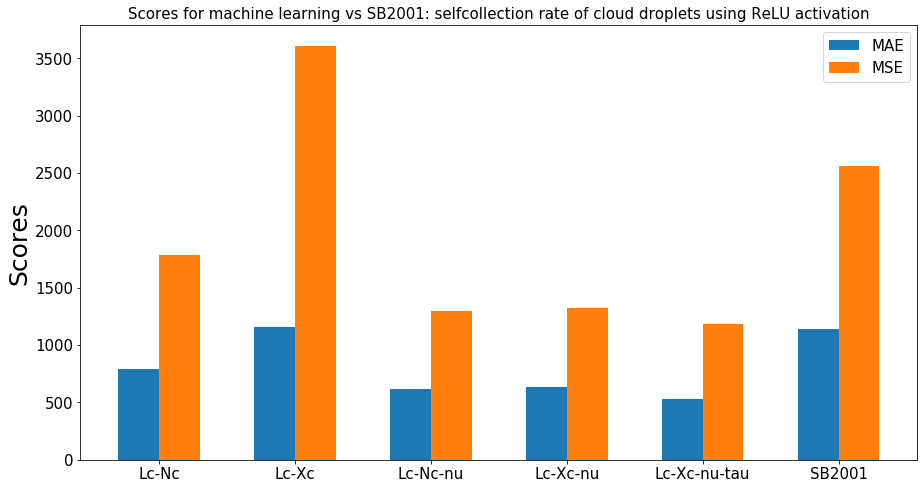

In [67]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (15,8)  # increase plot size
#labels = [ 'Lc-Lr', 'Lc-Lr-Nc', 'Lc-Lr-Nr', 'Lc-Lr-Nc-Nr', 'Lc-Lr-Nc-Nr-nu', 'SB2001' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae, width, label='MAE')
rects2 = ax.bar(x + width/2, mse, width, label='MSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for machine learning vs SB2001: selfcollection rate of cloud droplets using '+activ+' activation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#fig.tight_layout()

plt.show()

In [68]:
fig.savefig("selfCloud_barplot_v7_"+activ+"_eps15.png", bbox_inches='tight', dpi=600)

# Save models and normalization

In [69]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v7

model0.save('saved_model_v7/selfcloud_v7_LcNc_'+activ+'_16x16x16_'+data) 
model1.save('saved_model_v7/selfcloud_v7_LcXc_'+activ+'_16x16x16_'+data) 
model2.save('saved_model_v7/selfcloud_v7_LcNcNu_'+activ+'_16x16x16_'+data) 
model3.save('saved_model_v7/selfcloud_v7_LcXcNu_'+activ+'_16x16x16_'+data) 
model4.save('saved_model_v7/selfcloud_v7_LcXcNuTau_'+activ+'_16x16x16_'+data) 

# save train_stats for normalization of input data in Pandas pickle format
train_stats0.to_pickle('saved_model_v7/selfcloud_v7_LcNc_'+activ+'_16x16x16_'+data+'_norm.pickle')
train_stats1.to_pickle('saved_model_v7/selfcloud_v7_LcXc_'+activ+'_16x16x16_'+data+'_norm.pickle')
train_stats2.to_pickle('saved_model_v7/selfcloud_v7_LcNcNu_'+activ+'_16x16x16_'+data+'_norm.pickle')
train_stats3.to_pickle('saved_model_v7/selfcloud_v7_LcXcNu_'+activ+'_16x16x16_'+data+'_norm.pickle')
train_stats4.to_pickle('saved_model_v7/selfcloud_v7_LcXcNuTau_'+activ+'_16x16x16_'+data+'_norm.pickle')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model_v7/selfcloud_v7_LcNc_ReLU_16x16x16_big_n5/assets
INFO:tensorflow:Assets written to: saved_model_v7/selfcloud_v7_LcXc_ReLU_16x16x16_big_n5/assets
INFO:tensorflow:Assets written to: saved_model_v7/selfcloud_v7_LcNcNu_ReLU_16x16x16_big_n5/assets
INFO:tensorflow:Assets written to: saved_model_v7/selfcloud_v7_LcXcNu_ReLU_16x16x16_big_n5/assets
INFO:tensorflow:Assets written to: saved_model_v7/selfcloud_v7_LcXcNuTau_ReLU_16x16x16_big_n5/assets
